# Analysis of StackOverflow Survey. Part III

In [12]:
# import neccessary packages and libraries
import os
import sys
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# to render plots in the notebook
%matplotlib inline

import seaborn as sns
# set a theme for seaborn
sns.set_theme()

from sklearn.linear_model import LinearRegression

from sklearn import (
    ensemble,
    preprocessing,
    tree,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)
from sklearn.metrics import (
    r2_score, 
    mean_squared_error,
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

In [14]:
# import local module containing the neccessary functions
import utils_functions as uf

# forces the interpreter to re-import the module
import importlib
importlib.reload(uf);

In [15]:
# from https://stackoverflow.com/questions/40428931
# print to a file a list of packages and their versions used in this jupyter notebook

with open('packageinfo.txt', 'w') as f:
    print('Python {}'.format(sys.version), file=f)
    print('Packages:', file=f)
    print('\n'.join(f'{m.__name__} {m.__version__}' 
                    for m in globals().values() if getattr(m, '__version__', None)),file=f)

## State the question and outline

We are addressing the second question in this notebook. How do the salaries of data coders compare with the salaries of the other coders? In particular, we shall determine if there is a statistically significant difference between the average converted compensation of data coders versus the other coders.

We conduct a Z-test for independent means to compare the averages of the converted compensation, using the entries from the column 'imputedComp' obtained after imputing the missing values in 'ConvertedComp'. We will test the null hypothesis 
$$H_0: \mu_c \leq  \mu_o $$
that the mean converted compensation of the data coders ($\mu_c$) is larger than for the other coders ($\mu_o$), against the alternative
$$H_a: \mu_c > \mu_o $$

I will work with a $1 \%$ significance level so that $\alpha = 0.01$.

### Upload the processed data

In [19]:
# create a path string
mypath = os.getcwd()

# upload the datafiles as pandas dataframes
df1 = pd.read_csv(mypath+'/data/survey20_updated.csv')

# check the uploaded data
df1.shape

(60430, 33)

### Data Processing

In [20]:
# create a dataframe with the variables of interest only
df2 = pd.DataFrame([df1.imputedComp, df1.DevClass]).transpose()
df2.head(2)

,imputedComp,DevClass
0,62697.0,other_coder
1,67215.0,other_coder


In [21]:
# check the attributes of the dataframe
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60430 entries, 0 to 60429
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   imputedComp  60430 non-null  object
 1   DevClass     60430 non-null  object
dtypes: object(2)
memory usage: 944.3+ KB


In [22]:
# change the Dtype of the imputedComp column
df2['imputedComp'] = pd.to_numeric(df2["imputedComp"])
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60430 entries, 0 to 60429
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   imputedComp  60430 non-null  float64
 1   DevClass     60430 non-null  object 
dtypes: float64(1), object(1)
memory usage: 944.3+ KB


In [23]:
# determine how many entries have 0 compensation
df2[df2.imputedComp == 0.0].shape

(190, 2)

In [24]:
# drop those values with 0 imputedCompensation
df2.drop(df2[df2.imputedComp == 0.0].index, inplace = True)

In [25]:
# check for success
df2[df2.imputedComp == 0.0].shape

(0, 2)

In [26]:
# the records for the other coders
df2_other = df2[df2.DevClass == 'other_coder']
df2_other.shape

(51566, 2)

In [27]:
# the records for the data coders
df2_data = df2[df2.DevClass == 'data_coder']
df2_data.shape

(8674, 2)

In [19]:
# take a look at the data with profiling, save the output in a file
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df2)
# profile.to_file(output_file='imputedComp_profile.html')

<Figure size 1152x864 with 0 Axes>

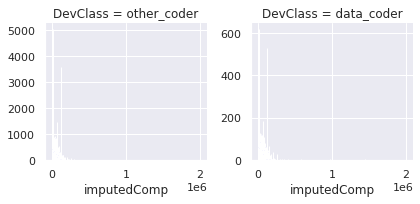

In [28]:
# resize the figure
plt.figure(figsize=[16, 12])

# create a facet plot with histograms for the two subsets
bin_edges = np.arange(-2, df2['imputedComp'].max()+1, 1000)
g = sns.FacetGrid(data = df2, col='DevClass', sharey=False)
g.map(plt.hist, 'imputedComp', bins=bin_edges, color='blue')

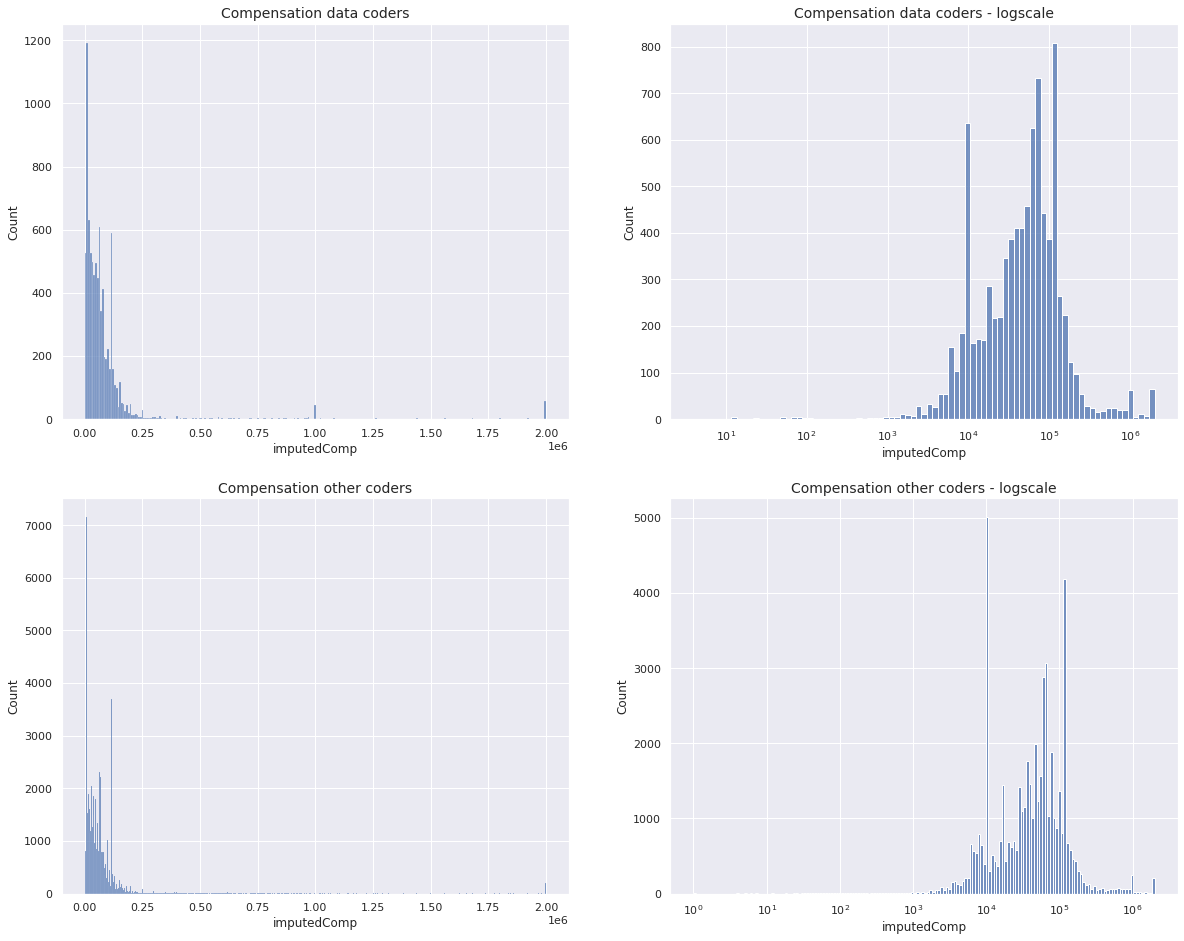

In [30]:
# set the figure sizecenter plot
plt.figure(figsize = [20, 16])

# left upper plot: histogram
plt.subplot(2, 2, 1)
sns.histplot(data=df2_data, x='imputedComp');
plt.title('Compensation data coders', fontsize=14);


# right upper plot: histogram
plt.subplot(2, 2, 2)
sns.histplot(data=df2_data, x='imputedComp',log_scale = True);
plt.title('Compensation data coders - logscale', fontsize=14);

# left lower plot: histogram
plt.subplot(2, 2, 3)
sns.histplot(data=df2_other, x='imputedComp');
plt.title('Compensation other coders', fontsize=14);

# right lower plot: histogram
plt.subplot(2, 2, 4)
sns.histplot(data=df2_other, x='imputedComp',log_scale = True );
plt.title('Compensation other coders - logscale', fontsize=14);


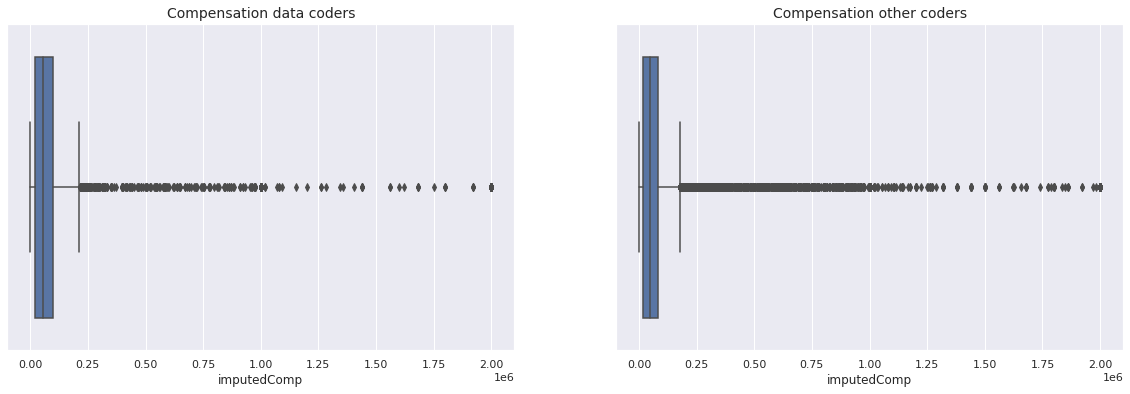

In [31]:
# set the figure sizecenter plot
plt.figure(figsize = [20, 6])

# left upper plot: histogram
plt.subplot(1, 2, 1)
sns.boxplot(data=df2_data, x='imputedComp');
plt.title('Compensation data coders', fontsize=14);


# right upper plot: histogram
plt.subplot(1, 2, 2)
sns.boxplot(data=df2_other, x='imputedComp');
plt.title('Compensation other coders', fontsize=14);

### Evaluate statistics

In [33]:
# create the two data arrays for the z-test
x_data = df2_data.imputedComp
x_other = df2_other.imputedComp


In [39]:
from scipy.stats import ttest_ind
statistic,pvalue = ttest_ind(x_other, x_data, equal_var=False, alternative='less')
print('The test statistic is %.3f and the p-value is %.5f'%(statistic,pvalue))

The test statistic is -6.775 and the p-value is 0.00000


#### Comments regarding the Z-test:

We test the null hypothesis 
$$H_0: \mu_c - \mu_o  \geq 0$$
that the mean converted compensation of the data coders ($\mu_c$) is larger than for the other coders ($\mu_o$), against the alternative
$$H_a: \mu_c - \mu_o  < 0.$$

I will work with a $1 \%$ significance level so that $\alpha = 0.01$.

We perform a right - tailed test and a Z-test of two means, with known population standard deviations. 

For the significance level of $\alpha = 0.01$ the critical value is $z_{\scriptsize critical} = 2.33$  with rejection region $R = \lbrace z: z > 2.33 \rbrace$. 

We compute a z-statistic $z = 6.775 \geq 2.33$ and we conclude that the null hypothesis is rejected. 

Using the p-value approach: since the p-value $p=0 < 0.01$, we conclude that he null hypothesis is rejected again.

We have $99 \%$ confidence that the mean compensation for data coders $\mu_c$ lies in the interval $[10016.38 + \mu_o, 22305.62 + \mu_o]$. 

A few comments about these conclusions:
- about $46 \%$ of the data is missing in the ConvComp column;
- we imputed most of the values with the country medians and droped the remaining zero and missing values;
- the compensation is converted, but we still have to keep in mind that the compensation levels differ substantially among countries;
- another aspect not taken into account (an this is only one of the many) is that the developers have various levels of seniority, and we averaged over all experience levels.

With all these observations in mind, we can just say that there is some evidence that, in average, the developers working with big data have higher compensation than the other developers. We can affirm, with a $99\%$ level of confidence, that this difference is somewhere between 10K and 20K.